In [44]:
import pandas as pd
import tensorflow as tf
import numpy as np
import ast

In [137]:
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")
manual_pred = pd.read_csv("predictions_manuall.csv")

In [138]:
train_df['category'] = train_df['category'].apply(ast.literal_eval)
test_df['category'] = test_df['category'].apply(ast.literal_eval)

In [139]:
train_categories_tensor = tf.ragged.constant(train_df["category"].values)
test_categories_tensor = tf.ragged.constant(test_df["category"].values)

# Convert TensorFlow tensors to numpy arrays
train_categories_array = train_categories_tensor.numpy()
test_categories_array = test_categories_tensor.numpy()

# Convert numpy arrays to sets of tuples
train_categories = set(tuple(x) for x in train_categories_array)
test_categories = set(tuple(x) for x in test_categories_array)

categories_not_in_train = test_categories - train_categories

print(categories_not_in_train)


set()


In [142]:
import tensorflow as tf
#
categories = tf.ragged.constant(train_df["category"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot", num_oov_indices=0)
lookup.adapt(categories)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


# Save your category labels to a file
with open('categories.txt', 'w') as f:
    for category in vocab:  # 'vocab' is your list of unique category labels
        f.write(f"{category}\n")

print("Vocabulary:\n")
print(vocab)

2023-06-04 13:18:10.745584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant and shape [288]
	 [[{{node Placeholder/_0}}]]


Vocabulary:

['Land use', 'other', 'Environment and climate resilience', 'Local identity', 'Future of work', 'Mobility (transport)']


In [143]:
sample_label = train_df["category"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Mobility (transport)', 'Future of work']
Label-binarized representation: [[0. 0. 0. 0. 1. 1.]]


In [144]:
train_df["Sentence"].apply(lambda x: len(x.split(" "))).describe()

count    288.000000
mean      13.864583
std       24.931664
min        1.000000
25%        5.000000
50%        8.000000
75%       13.000000
max      179.000000
Name: Sentence, dtype: float64

In [145]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_seqlen = 20
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["category"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["Sentence"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [146]:
vocabulary = set()
train_df["Sentence"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

1071


In [147]:
train_dataset = make_dataset(train_df, is_train=True)
test_dataset = make_dataset(test_df, is_train=False)

In [148]:
import numpy as np
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(label[0])
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")


[0. 1. 0. 0. 0. 0.]
Abstract: b'"That\'s great who were your teachers"'
Label(s): ['other']
 
[1. 0. 0. 0. 0. 0.]
Abstract: b'"the building should have kinda isolated spaces that make the students collaborate in separated groups"'
Label(s): ['Land use']
 
[1. 0. 0. 0. 0. 0.]
Abstract: b'"and shops on ground floor"'
Label(s): ['Land use']
 
[0. 0. 1. 0. 0. 0.]
Abstract: b'"Is there a cooling system?"'
Label(s): ['Environment and climate resilience']
 
[1. 0. 0. 0. 0. 0.]
Abstract: b'"the building should have connected spaces for workshop between students"'
Label(s): ['Land use']
 


2023-06-04 13:18:16.891596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [288,6]
	 [[{{node Placeholder/_1}}]]
2023-06-04 13:18:16.892047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [288,6]
	 [[{{node Placeholder/_1}}]]


In [149]:
from tensorflow.keras import layers
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# You need to adapt your vectorizer to the text data
text_vectorizer.adapt(train_df["Sentence"].values)

vocab2 = text_vectorizer.get_vocabulary()
with open('vocabulary.txt', 'w') as f:
    for word in vocab2:
        f.write(f"{word}\n")
print(vocab2)
# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


['[UNK]', 'the', 'building', 'and', 'be', 'a', 'to', 'should', 'of', 'it', 'the building', 'have', 'i', 'for', 'you', 'in', 'that', 'would', 'should be', 'is', 'can', 'as', 'with', 'spaces', 'have a', 'it should', 'building should', 'more', 'do', 'use', 'think', 'there', 'on', 'how', 'like', 'students', 'of the', 'also', 'what', 'or', 'do you', 'could', 'would be', 'will', 'this', 'space', 'i think', 'many', 'in the', 'nice', 'for the', 'design', 'an', 'to the', 'should have', 'new', 'architecture', 'we', 'tum', 'open', 'on the', 'materials', 'about', 'so', 'not', 'be a', 'your', 'possible', 'i would', 'which', 'where', 'see', 'rooms', 'it would', 'floor', 'be nice', 'yes', 'work', 'well', 'there should', 'some', 'positive', 'if', 'green', 'great', 'environment', 'by', 'up', 'to see', 'the tum', 'the new', 'the environment', 'student', 'spaces for', 'place', 'nice to', 'my', 'look', 'good', 'existing', 'different', 'definitely', 'construction', 'at', 'are', 'a positive', 'would also', 

2023-06-04 13:18:18.311445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [288]
	 [[{{node Placeholder/_0}}]]
2023-06-04 13:18:18.311876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [288,6]
	 [[{{node Placeholder/_1}}]]


In [150]:
from collections import Counter
from itertools import chain

# Flatten the list of categories and count the occurrences
class_counts = dict(Counter(chain(*train_df['category'])))

# Calculate total number of samples
total_samples = len(train_df)

# Calculate class weights
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Convert class_weights to tensor format
class_weights_tensor = tf.constant([class_weights[key] for key in sorted(class_weights.keys())])
class_weights

{'Mobility (transport)': 28.8,
 'Future of work': 7.384615384615385,
 'Environment and climate resilience': 4.721311475409836,
 'other': 4.114285714285714,
 'Local identity': 4.88135593220339,
 'Land use': 3.3488372093023258}

In [151]:
def make_model():
    shallow_mlp_model = tf.keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

Epoch 1/16


2023-06-04 13:18:24.231065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [288,6]
	 [[{{node Placeholder/_1}}]]
2023-06-04 13:18:24.231724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype int64
	 [[{{node Placeholder/_12}}]]


3/3 [==============================] - 4s 11ms/step - loss: 1.4536 - binary_accuracy: 0.4427 - precision: 0.2265 - recall: 0.8195 - f1_score: 0.3549
Epoch 2/16
3/3 [==============================] - 0s 12ms/step - loss: 1.3868 - binary_accuracy: 0.5677 - precision: 0.2342 - recall: 0.7611 - f1_score: 0.3581
Epoch 3/16
3/3 [==============================] - 0s 15ms/step - loss: 1.3652 - binary_accuracy: 0.6424 - precision: 0.2471 - recall: 0.6958 - f1_score: 0.3646
Epoch 4/16
3/3 [==============================] - 0s 12ms/step - loss: 1.3474 - binary_accuracy: 0.6343 - precision: 0.2553 - recall: 0.6751 - f1_score: 0.3705
Epoch 5/16
3/3 [==============================] - 0s 14ms/step - loss: 1.3286 - binary_accuracy: 0.6267 - precision: 0.2646 - recall: 0.6870 - f1_score: 0.3821
Epoch 6/16
3/3 [==============================] - 0s 13ms/step - loss: 1.3063 - binary_accuracy: 0.6678 - precision: 0.2721 - recall: 0.6905 - f1_score: 0.3903
Epoch 7/16
3/3 [==============================] - 0

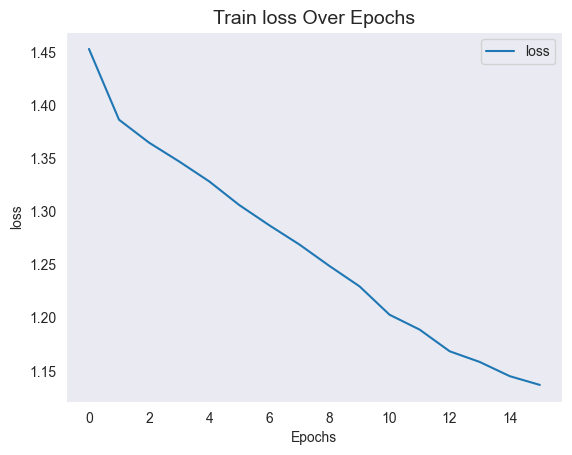

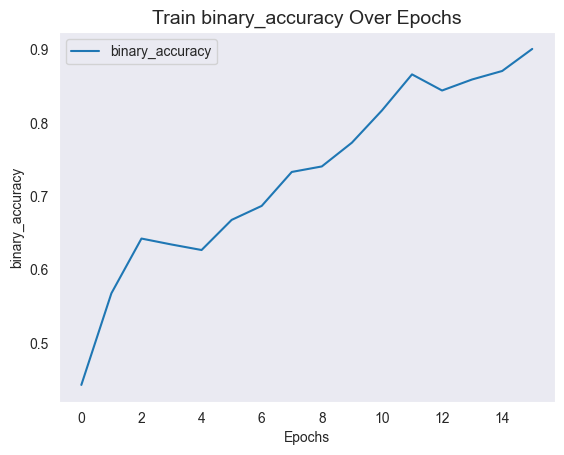

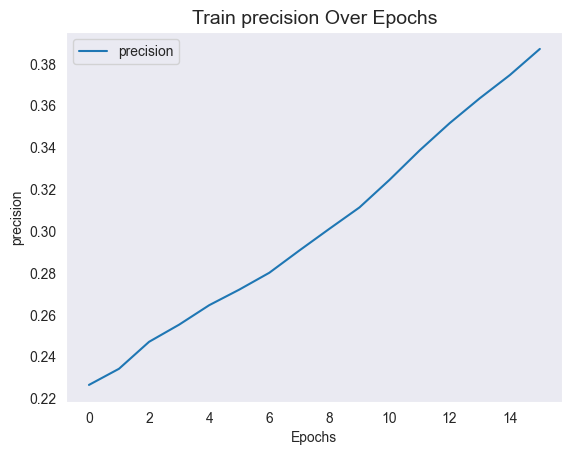

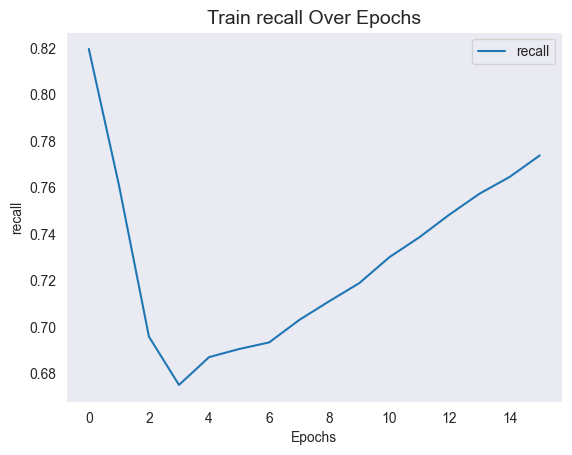

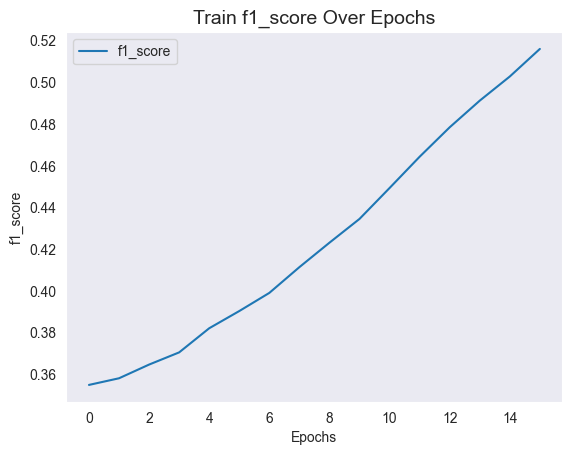

In [152]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.keras import metrics

import tensorflow as tf
#from tensorflow.keras import metrics

class F1Score(metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = metrics.Precision()
        self.recall = metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
       precision = self.precision.result()
       recall = self.recall.result()
       return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
# Define weighted loss function
def weighted_binary_crossentropy(y_true, y_pred):
    return tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, class_weights_tensor)


epochs = 16

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss=weighted_binary_crossentropy,
    optimizer="adam",
    metrics=[
        "binary_accuracy", #"binary_accuracy" checks for each position if the prediction is correct.
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        F1Score()
    ]
)

history = shallow_mlp_model.fit(train_dataset, epochs=epochs)
# Save the entire model as a SavedModel.
shallow_mlp_model.save('TFIDF|_Model.h5')

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss")
plot_result("binary_accuracy")
plot_result("precision")
plot_result("recall")
plot_result("f1_score")


In [153]:
# Generate predictions on the test set
y_pred = shallow_mlp_model.predict(test_dataset)
def custom_round(y_pred, threshold):
    binary_predictions = np.zeros_like(y_pred)

    for i, row in enumerate(y_pred):
        if np.all(row < threshold):
            binary_predictions[i, np.argmax(row)] = 1
        else:
            binary_predictions[i] = np.round(row)

    return binary_predictions

binary_predictions = custom_round(y_pred, threshold=0.5)
binary_predictions

1/1 [==============================] - 0s 143ms/step


2023-06-04 13:18:30.956968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype int64
	 [[{{node Placeholder/_7}}]]
2023-06-04 13:18:30.957745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64
	 [[{{node Placeholder/_9}}]]


array([[1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1.

In [154]:
y_true = np.vstack(test_dataset.map(lambda x, y: y).as_numpy_iterator())
y_true

2023-06-04 13:18:32.992520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64
	 [[{{node Placeholder/_9}}]]
2023-06-04 13:18:32.993261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1071]
	 [[{{node Placeholder/_10}}]]
/var/folders/jp/2wr1hx0s4zjdcnf63gtk75fw0000gq/T/ipykernel_80174/2842722914.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(test_dataset

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [0.

In [155]:
def get_true_prediction(row):
    if row['Verification'] == 'V':
        return row['Predicted Labels']
    elif row['Verification'] == 'X':
        return row['True Labels']
    else:
        return None

manual_pred['true prediction'] = manual_pred.apply(get_true_prediction, axis=1)


In [156]:
manual_pred.to_csv("predictions_manuall2.csv",index=False)

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def eval(category):
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in manual_pred.index:
        if category in manual_pred['true prediction'][i] and category in manual_pred['Predicted Labels'][i]:
            TP += 1
        elif category in manual_pred['Predicted Labels'][i] and category not in manual_pred['true prediction'][i]:
            FP +=1
        elif category in manual_pred['true prediction'][i] and category not in manual_pred['Predicted Labels'][i]:
            FN +=1
        elif category not in manual_pred['true prediction'][i] and category not in manual_pred['Predicted Labels'][i]:
            TN +=1

    accuracy = (TP + TN) / (TP + TN + FN + FP) if (TP + TN + FN + FP) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    F1score = 2*precision*recall / (precision + recall) if (precision + recall) != 0 else 0

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {F1score}")

    confusion_matrix = pd.DataFrame({
        'Predicted Positive': [TP, FP],
        'Predicted Negative': [FN, TN]
    }, index=['Actual Positive', 'Actual Negative'])

    plt.figure(figsize=(5,5))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap='Blues')
    plt.title(f"Confusion Matrix for '{category}'")
    plt.show()

Accuracy: 0.9027777777777778
Precision: 0.8888888888888888
Recall: 0.5714285714285714
F1 Score: 0.6956521739130435


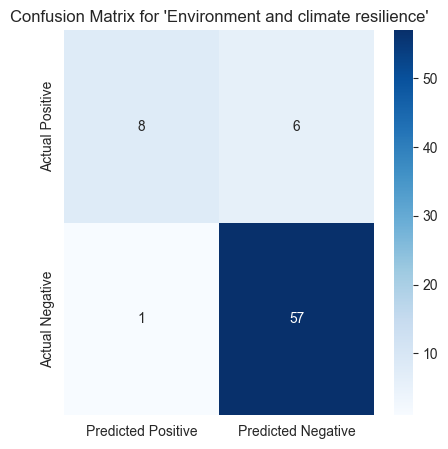

Accuracy: 0.8888888888888888
Precision: 0.8260869565217391
Recall: 0.8260869565217391
F1 Score: 0.8260869565217391


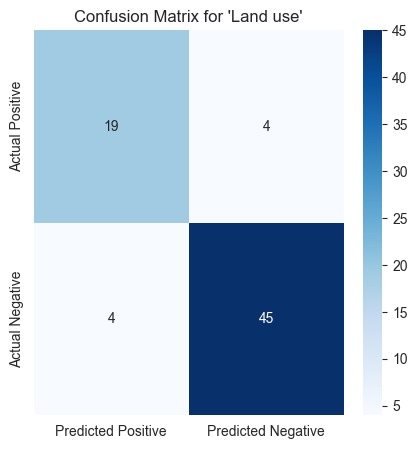

Accuracy: 0.8333333333333334
Precision: 0.7073170731707317
Recall: 1.0
F1 Score: 0.8285714285714285


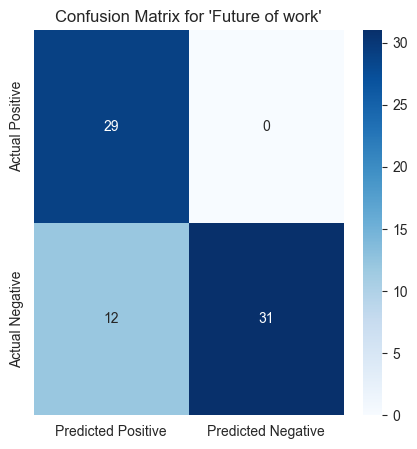

Accuracy: 0.9861111111111112
Precision: 1.0
Recall: 0.875
F1 Score: 0.9333333333333333


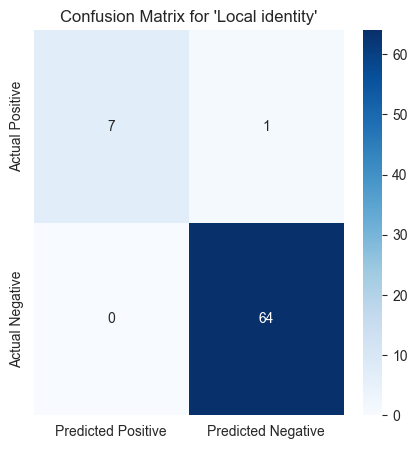

Accuracy: 1.0
Precision: 0
Recall: 0
F1 Score: 0


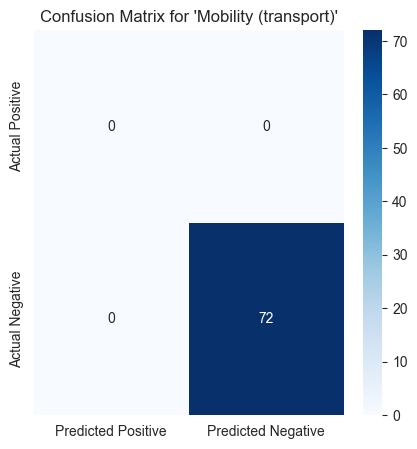

Accuracy: 0.9444444444444444
Precision: 0.9565217391304348
Recall: 0.88
F1 Score: 0.9166666666666666


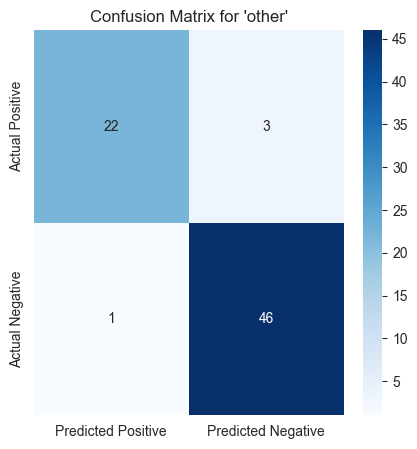

In [174]:
eval('Environment and climate resilience')
eval('Land use')
eval('Future of work')
eval('Local identity')
eval('Mobility (transport)')
eval('other')